In [8]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=0ebe6f33e3ca19e2eb557d5e99a4490ae67a41daf29c961e08caedc69a8088e1
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [9]:
import tweepy          
import pandas as pd    
import numpy as np      
import twitter
from credentials import *   
from textblob import TextBlob
import re
from stop_words import get_stop_words
from collections import Counter
import simplejson as json
#from utils.PickleManager import *stop_words = get_stop_words('en')
#import os from django_setup.settings import compressFileDir,twitterFileDir

In [11]:
def userAuthentication():
    auth = tweepy.OAuthHandler('O7BKFNsZxT6o2faDsIoQSIAgl', 'u4W6cqXkngniTBC6GUUUN0bxfGog6Zo5j2G4JaNOlyJecUHB4s')
    auth.set_access_token('154894359-VoYFfUuUBKxquxrLpURALnLCNe5fU9ZFNwXSW5dm', 'Ic3ywx9OXefHFIyIWFlmpvXfckaaCbAFPvC2l37FoXvbU')
    twitter_api = tweepy.API(auth)
    return twitter_api
twitter_api = userAuthentication()

query = "@WHO"
msgs=[]
tQryData =  tweepy.Cursor(twitter_api.search, q=query).items(int(500))
for tweet in tQryData:
    msg = [tweet.text,len(tweet.text),tweet.id,tweet.favorite_count,tweet.retweet_count,tweet.source, tweet.source_url,tweet.created_at,tweet.user.profile_image_url,tweet.user.name,tweet.user.screen_name,tweet.geo,tweet.user.location,tweet.entities.get('hashtags')]
    msg = tuple(msg)
    msgs.append(msg)

df = pd.DataFrame(msgs)
df.columns = ['tweets','text_length','id','likes','retweets', 'source', 'url','created_at','image_url','author_name','author_screen_name','geo','location','hashtags']







In [12]:
df

,tweets,text_length,id,likes,retweets,source,url,created_at,image_url,author_name,author_screen_name,geo,location,hashtags
0,@DrTedros @presidentaz @WHO HAAG !!!,36,1378714098590957575,0,0,Twitter Web App,https://mobile.twitter.com,2021-04-04 14:20:31,http://pbs.twimg.com/profile_images/1187366193...,xrPeter,XRP1procent,None,,[]
1,RT @DrTedros: In my call with @presidentaz ear...,139,1378714067355975686,0,6,Twitter for Android,http://twitter.com/download/android,2021-04-04 14:20:23,http://pbs.twimg.com/profile_images/1273996589...,Emin Aslan,EminAslanAZ,None,"Geneva, Switzerland",[]
2,RT @PBnrg: Dear @DaburIndia please share the d...,140,1378714058585559043,0,68,Twitter for Android,http://twitter.com/download/android,2021-04-04 14:20:21,http://pbs.twimg.com/profile_images/1245552353...,Jugnu,Jugnu10938481,None,,[]
3,RT @PBnrg: Dear @DaburIndia please share the d...,140,1378713974418632707,0,68,Twitter for Android,http://twitter.com/download/android,2021-04-04 14:20:01,http://pbs.twimg.com/profile_images/1363385257...,M0lar,tarladalalfc,None,,[]
4,RT @WainnieT: #VerifiedWithdrawalOfEritrea\n#T...,140,1378713919544565764,0,1,Twitter for Android,http://twitter.com/download/android,2021-04-04 14:19:48,http://pbs.twimg.com/profile_images/1368600974...,Kinfemichael Tsehaye,KinfemichaelTs1,None,,"[{'text': 'VerifiedWithdrawalOfEritrea', 'indi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,RT @LunaDeCafe: @aletopia @DrNetas @IPN_MX @Cl...,139,1378685447614894084,0,269,Twitter for Android,http://twitter.com/download/android,2021-04-04 12:26:40,http://pbs.twimg.com/profile_images/1259988063...,Alberto Gutiérrez,guba0610,None,,[]
496,RT @ishdeep_kohli: @salhaj @deyanakosta @gavi ...,140,1378685444498542599,0,4,Twitter for iPhone,http://twitter.com/download/iphone,2021-04-04 12:26:39,http://pbs.twimg.com/profile_images/1255585393...,Ishdeep Kohli,ishdeep_kohli,None,,[]
497,"#Iran,#Coronavirus:+242,700 deaths\n#COVID19\n...",139,1378685436869103617,0,0,Twitter Web App,https://mobile.twitter.com,2021-04-04 12:26:37,http://pbs.twimg.com/profile_images/1270766123...,Iranian Community Romania,IranianRomania,None,,"[{'text': 'Iran', 'indices': [0, 5]}, {'text':..."
498,What are you waiting for!\nTigray Genocide is ...,140,1378685429952753667,0,0,Twitter for iPhone,http://twitter.com/download/iphone,2021-04-04 12:26:35,http://abs.twimg.com/sticky/default_profile_im...,Zeyo Mogus,MogusZeyo,None,,[]


In [13]:
import nltk

In [14]:
from nltk.corpus import stopwords 

In [15]:
from nltk.stem.porter import PorterStemmer

In [18]:
df["tweets"]=df["tweets"].astype(str)

In [19]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [30]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:

df["Tweets_clean"] = df["tweets"].apply(lambda x: clean_text(x))

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["tweets"].apply(lambda x: sid.polarity_scores(x))
#df = pd.concat([df.drop(['sentiments'], axis=1),df1['sentiments'].apply(pd.Series)], axis=1)


In [ ]:
df1.groupby('Useful Complains/Not Useful Complains')['neg'].count()

Useful Complains/Not Useful Complains
0    161
1     38
Name: neg, dtype: int64

In [32]:

# add number of characters column
df["nb_chars"] = df["tweets"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["tweets"].apply(lambda x: len(x.split(" ")))

In [33]:
pip install gensim

In [34]:
import gensim

In [ ]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Tweets_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df["Tweets_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df1.columns]
df = pd.concat([df, doc2vec_df], axis=1)

In [ ]:
df1.columns

Index(['Tweets', 'Useful Complains/Not Useful Complains', 'Useful/Useless',
       'Tweets_clean', 'neg', 'neu', 'pos', 'compound', 'nb_chars', 'nb_words',
       'doc2vec_vector_0', 'doc2vec_vector_1', 'doc2vec_vector_2',
       'doc2vec_vector_3', 'doc2vec_vector_4', 'word_arron_banks',
       'word_change', 'word_claireperrymp', 'word_climate', 'word_eu',
       'word_get', 'word_https', 'word_leave', 'word_like', 'word_markfielduk',
       'word_michaelgove', 'word_one', 'word_rt', 'word_set', 'word_think',
       'word_uk', 'word_would'],
      dtype='object')

In [ ]:
df2=df1[df1['Useful Complains/Not Useful Complains']==1]

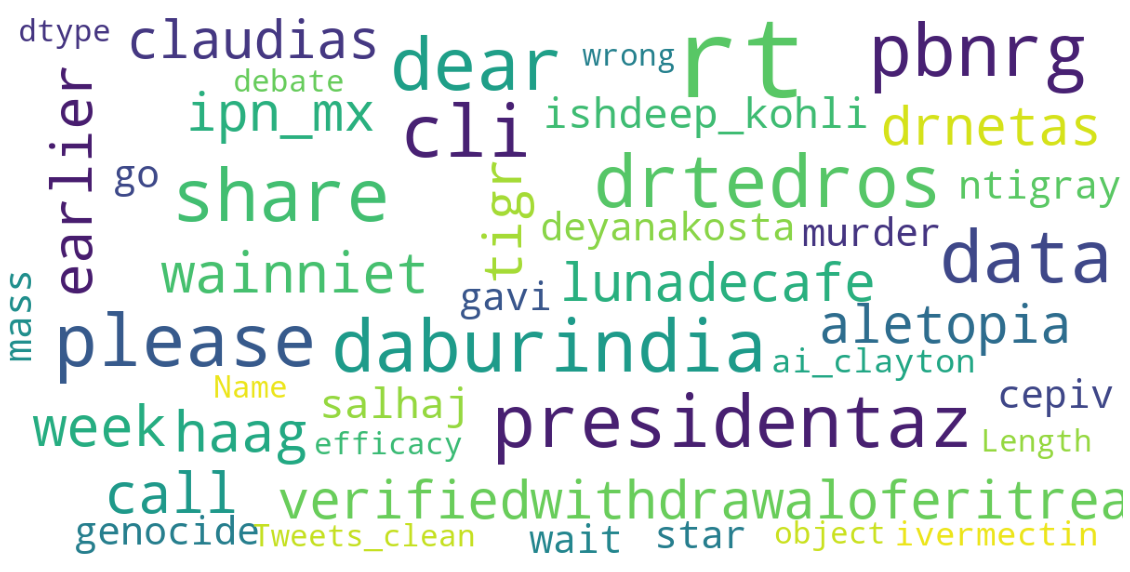

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["Tweets_clean"])
#view raw

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df1["Tweets_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df1.index
df1 = pd.concat([df1, tfidf_df], axis=1)

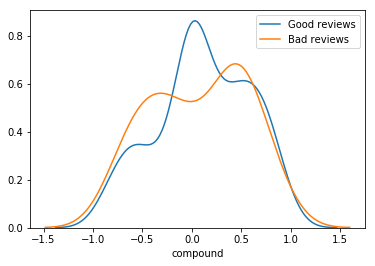

In [ ]:

# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = df1[df1[ 'Useful Complains/Not Useful Complains'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [ ]:
df1.columns

Index(['Tweets', 'Useful Complains/Not Useful Complains', 'Useful/Useless',
       'Tweets_clean', 'neg', 'neu', 'pos', 'compound', 'nb_chars', 'nb_words',
       'doc2vec_vector_0', 'doc2vec_vector_1', 'doc2vec_vector_2',
       'doc2vec_vector_3', 'doc2vec_vector_4', 'word_arron_banks',
       'word_change', 'word_claireperrymp', 'word_climate', 'word_eu',
       'word_get', 'word_https', 'word_leave', 'word_like', 'word_markfielduk',
       'word_michaelgove', 'word_one', 'word_rt', 'word_set', 'word_think',
       'word_uk', 'word_would'],
      dtype='object')

In [ ]:
df1["Useful Complains/Not Useful Complains"]=df1["Useful Complains/Not Useful Complains"].astype(str)
df1["Useful/Useless"]=df1["Useful/Useless"].astype(int)

In [ ]:
label = "Useful Complains/Not Useful Complains"
ignore_cols = [label, "Tweets", "Tweets_clean","Useful/Useless  "]
features = [c for c in df1.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1[features], df1[label], test_size = 0.40, random_state = 42)


In [ ]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
0,Useful/Useless,0.111176
5,nb_chars,0.106677
6,nb_words,0.086258
9,doc2vec_vector_2,0.078247
7,doc2vec_vector_0,0.069710
1,neg,0.067374
8,doc2vec_vector_1,0.063925
11,doc2vec_vector_4,0.055715
4,compound,0.047725
2,neu,0.047676


In [ ]:
from sklearn import metrics

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8625


In [ ]:
import xgboost as xgb

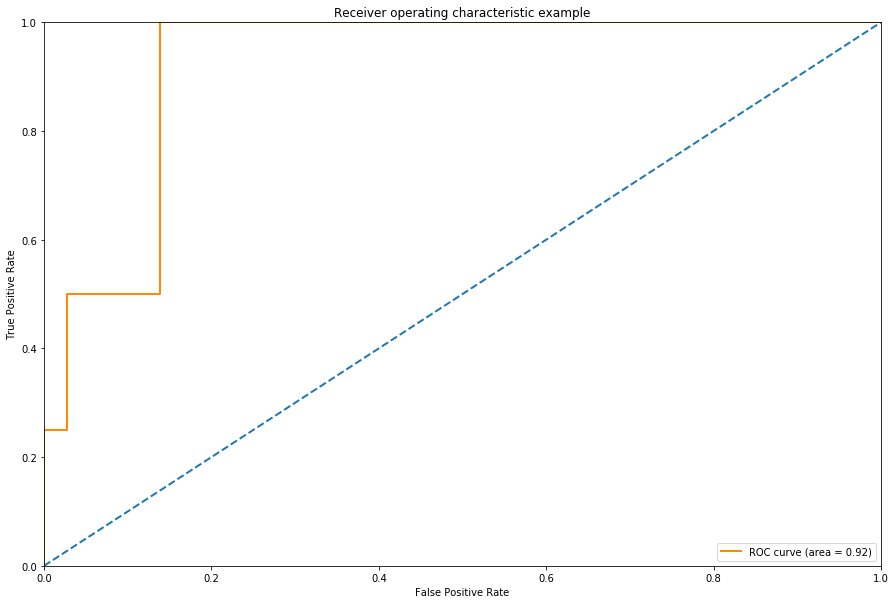

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df1.shape

(199, 32)

In [36]:
!pip install transformers


     |████████████████████████████████| 2.0MB 5.7MB/s 
     |████████████████████████████████| 3.2MB 32.3MB/s 
     |████████████████████████████████| 870kB 38.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=ac967bef2300dc0caac4a78e33f222b87ec597e445f6641c949e8619621da685
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)